In [1]:
from natsort import natsorted
import numpy as np
import os
import pandas as pd

#Helper Functions
from mat_to_py import csv_to_npy
from preprocessing import filter, preprocess

#Filtering
from scipy.signal import kaiserord, filtfilt, firwin, freqz, windows, cheby2, iirnotch, welch

#Plotting
from pylab import figure, clf, plot, subplot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Data Loading & Visualization

After running the get_data.m script to get .csv files out of Matlab, we turn them into .npy files with the code below.

In [ ]:
dir = "C:/Users/Daydreamore/Desktop/Semester/BCI"
csv_to_npy(dir)

Sanity check to see if the data approximately has the right dimensions.

In [31]:
for i in range(16):
    x = np.load("sub{}_data.npy".format(i+1))
    print(x.shape)

(24, 539753)
(24, 555727)
(23, 517388)
(23, 512394)
(23, 518385)
(23, 571660)
(23, 610010)
(24, 475409)
(23, 527484)
(24, 590691)
(22, 489942)
(24, 488451)
(24, 473926)
(23, 436432)
(23, 529390)
(24, 484438)


Before we start the preprocessing, let's have a rough look at the EEG data of a participant. 

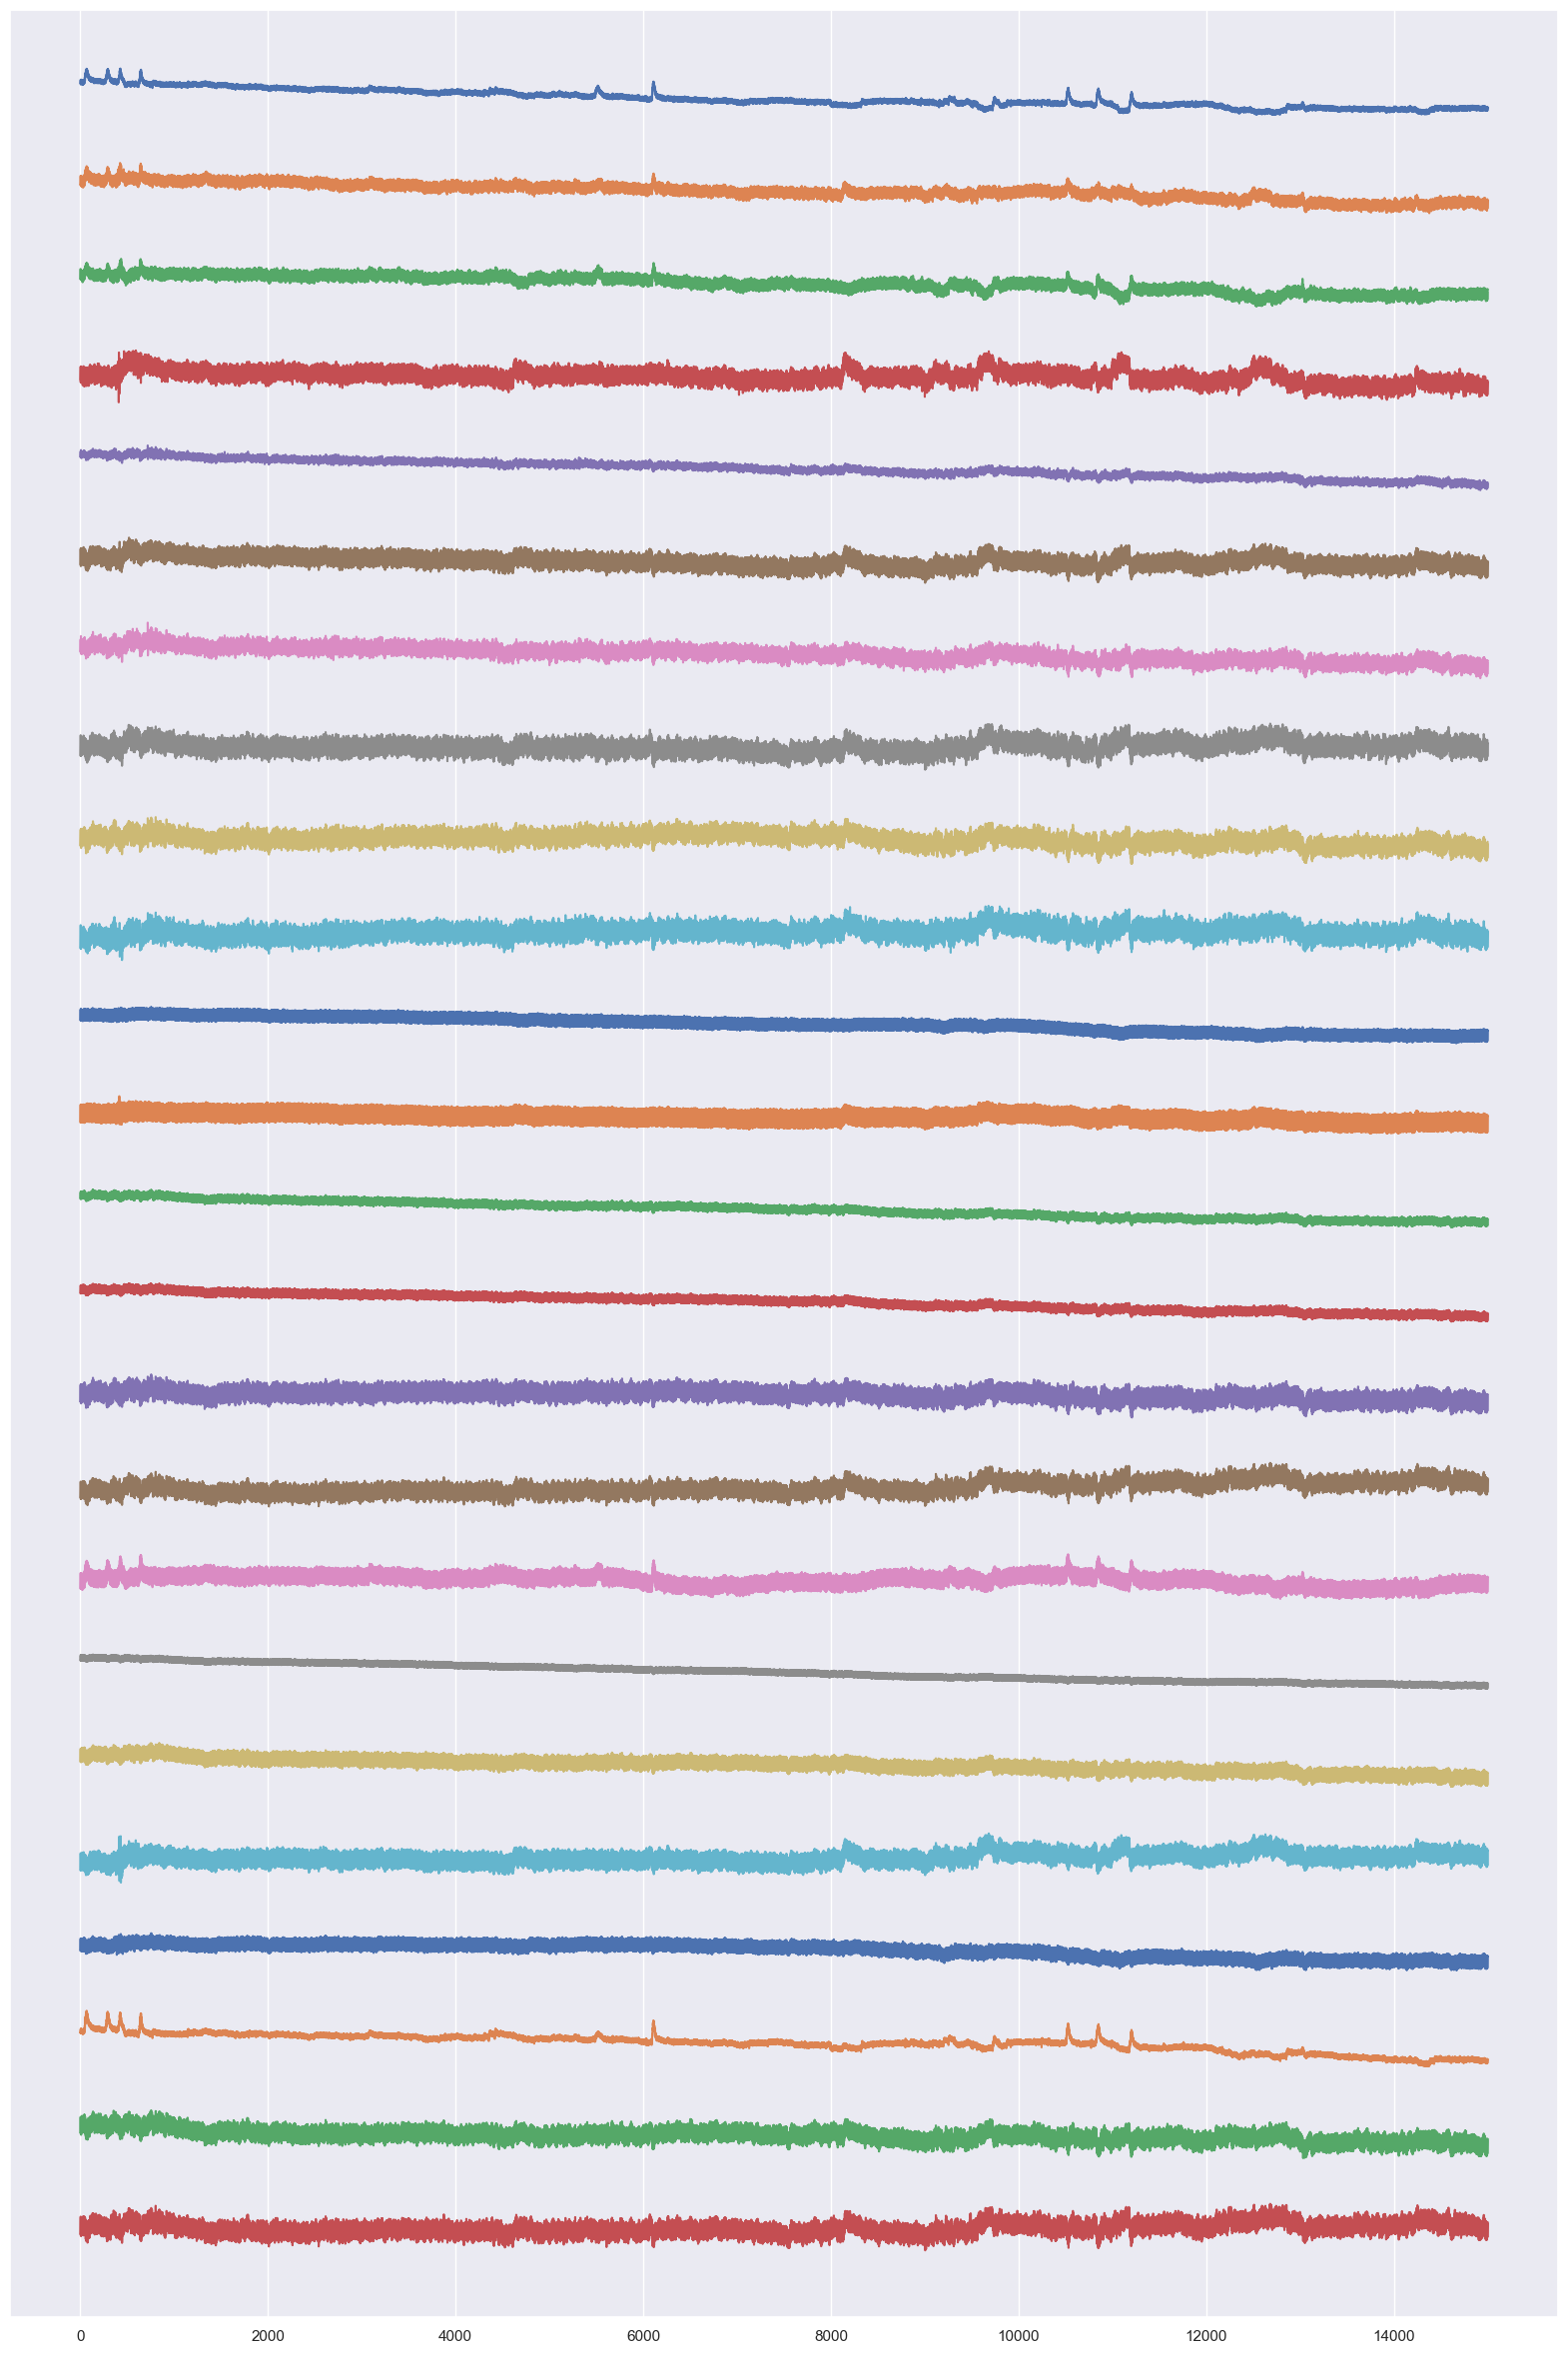

In [3]:
#Let's take subsample of an example recording
x = np.load("sub1_data.npy", allow_pickle=True)
x_sub = x[:,0:15000] #1min

#Just for the visualization, we standardize the data per row --> (x-mean(x))/std(x)
for ix, row in enumerate(x_sub):
    x_sub[ix] = (row-np.mean(row, axis=0))/np.std(row)

#We introduce some shift to better tell the channels apart in the plot
shift = np.tile(np.linspace(0,-240,x_sub.shape[0]), (15000,1)).T
x_shift = x_sub + shift

plt.figure(figsize = (20,30))
plt.ylim((-250, 10))
plt.plot(x_shift.T) #eeg data
labels = plt.gca()
labels.axes.get_yaxis().set_visible(False) #hide y-labels (not informative)
plt.show()

## Filtering: Design, Plotting, and Filter Function
The plots show the frequency response of the respective filters, as well as the changes in the time domain and the psd.
Note: different to the paper, I decided to also apply a Notch filter at 62Hz to get rid of the VR headset noise.

1. Plotting lowpass & highpass response of Cheby2 vs. Kaiser filter in frequency & time domain.

C:\Users\Daydreamore\AppData\Local\Temp\ipykernel_20240\1013224537.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,2,1)
C:\Users\Daydreamore\AppData\Local\Temp\ipykernel_20240\1013224537.py:102: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(3,2,1)


Text(0.5, 1.0, 'b) Highpassed Signal Overlayed on Raw Signal')

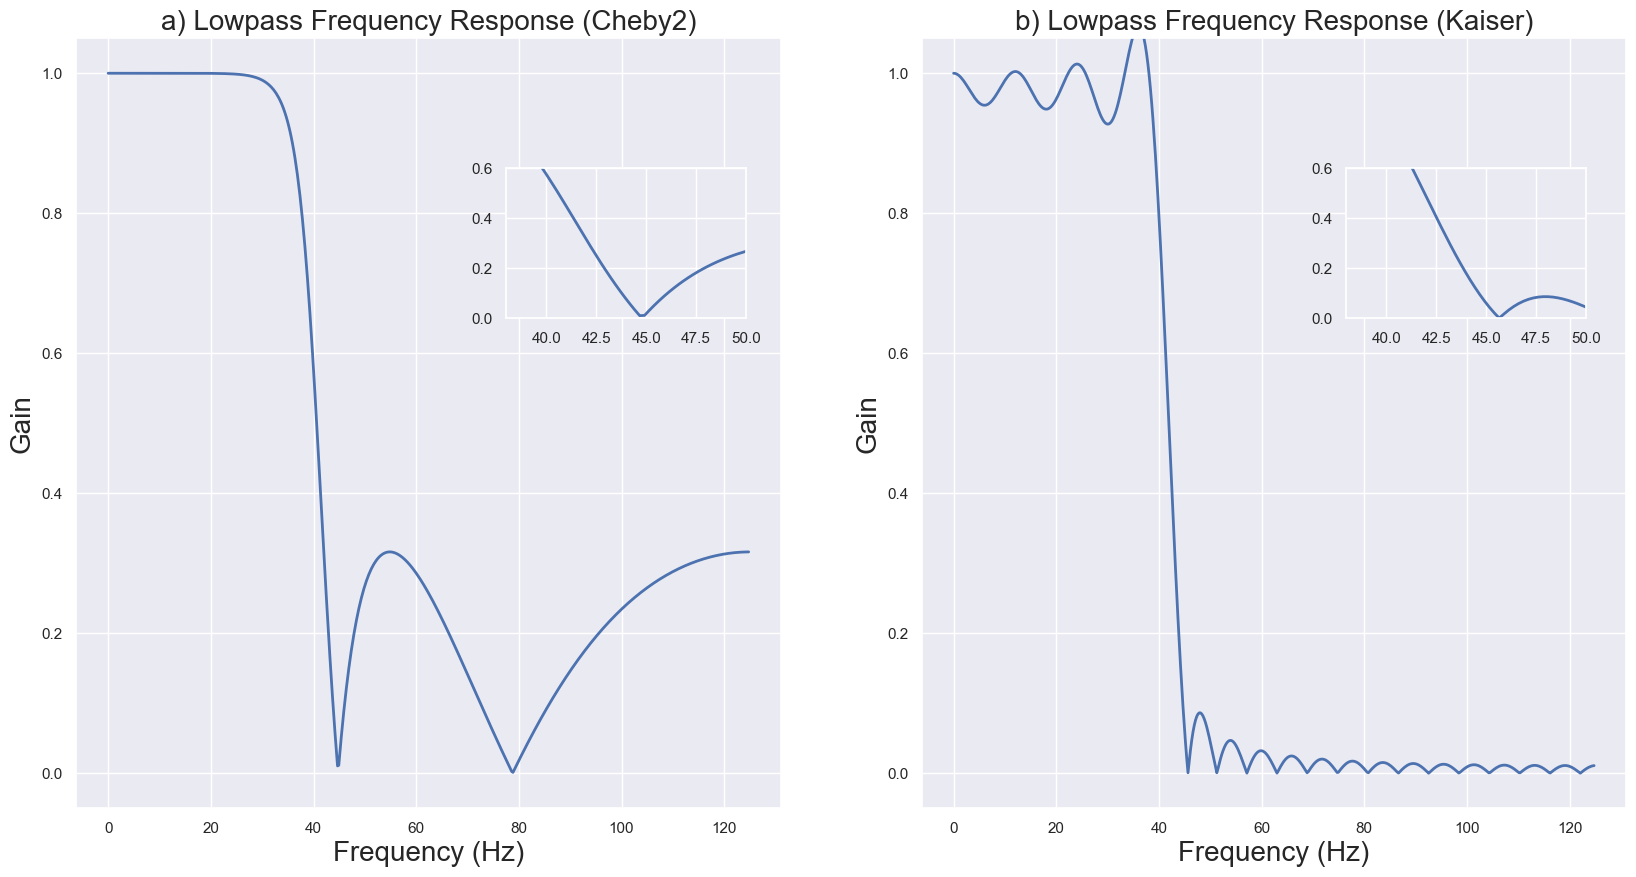

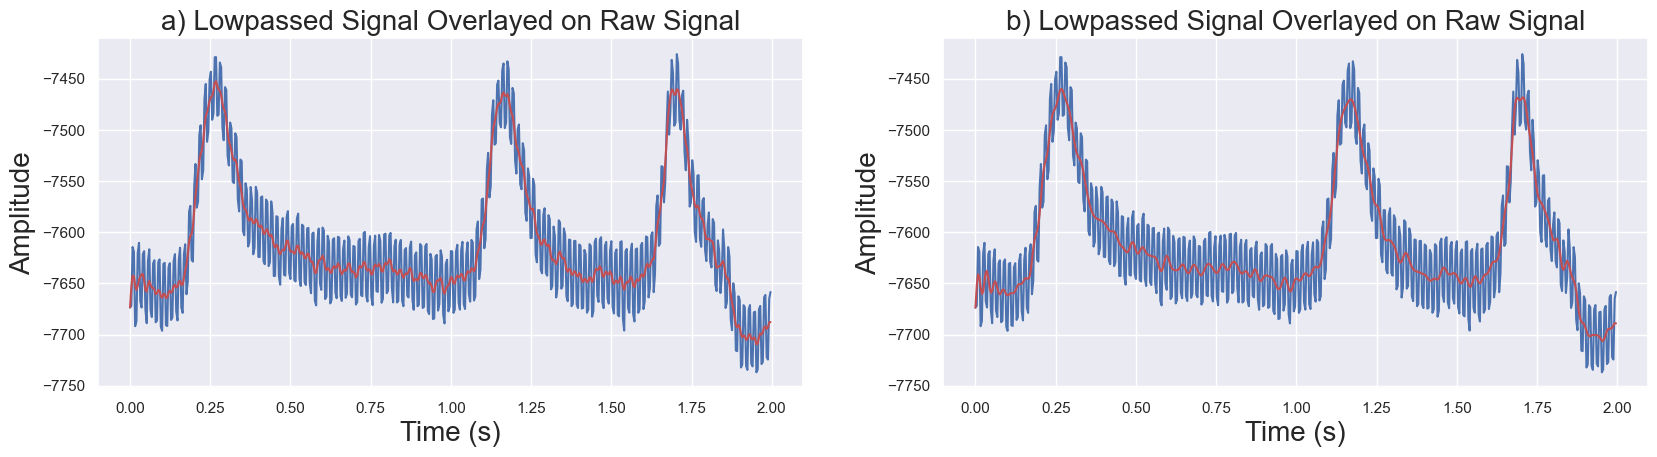

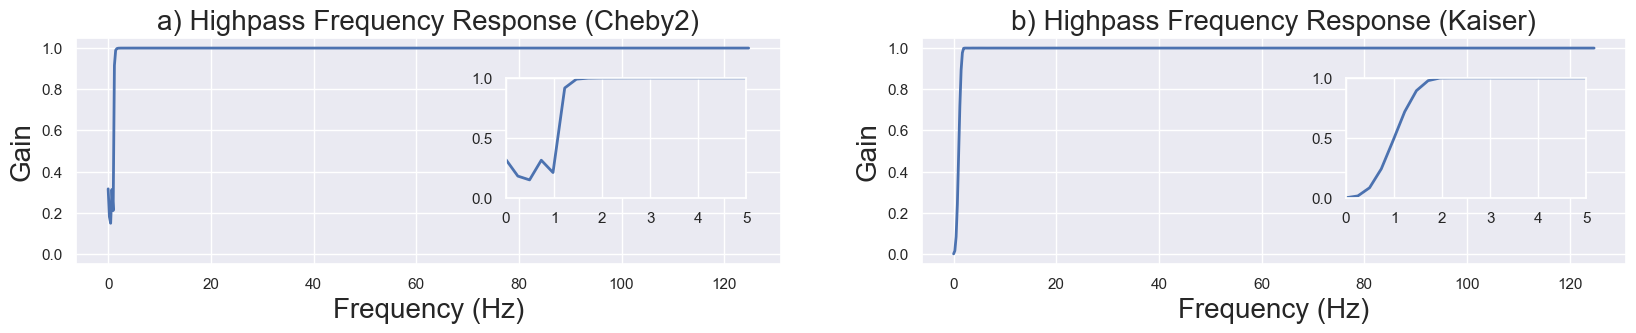

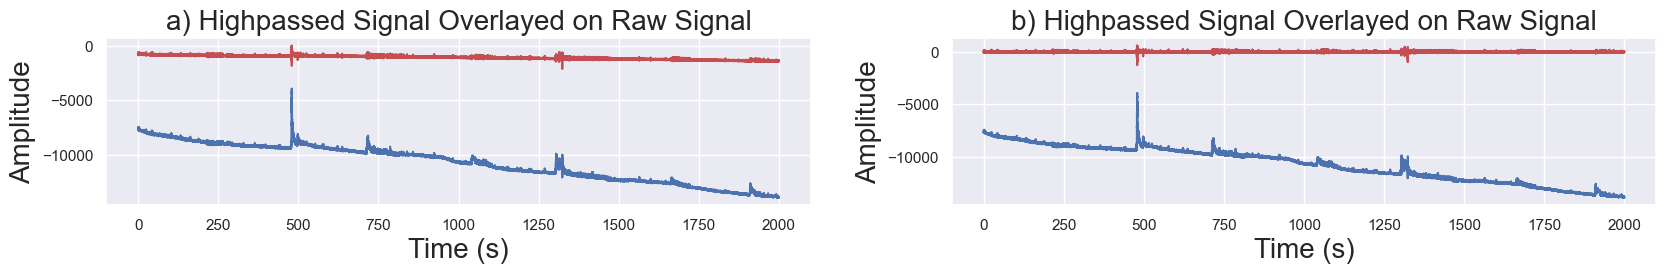

In [39]:
fs = 250
n_samples = x.shape[1]
nyq = fs/2.0

#Cutoff Frequencies
high_cut = 1.0/nyq
low_cut = 42/nyq
notch_cut1 = 50 #normalized inside scipy function
notch_cut2 = 100

#Cheby2
#Highpass Filter (Cheby)
b_ch, a_ch = cheby2(4, 10, high_cut, btype = "high", output = "ba")
w_ch, h_ch = freqz(b_ch, a_ch, worN=512)
#Lowpass Filter (Cheby)
b_cl, a_cl = cheby2(4, 10, low_cut, btype = "low", output = "ba")
w_cl, h_cl = freqz(b_cl, a_cl, worN=512)

#Kaiser
#Highpass and Lowpass Filter 
#Width of transition from pass to stop relative to Nyquist.
width_low = 5.0/nyq #15 Hz transition rate
width_high = 2.0/nyq
#Desired attenuation in the stop band, in dB.
ripple_db_low = 20.0
ripple_db_high = 72.0
#Compute the order and Kaiser parameter for the FIR filter.
N_low, beta_low = kaiserord(ripple_db_low, width_low)
N_high, beta_high = kaiserord(ripple_db_high, width_high)
#Use firwin with a Kaiser window to create a lowpass and highpass FIR filter.
taps_low = firwin(N_low, low_cut,window=('kaiser', beta_low)) #Kaiser: window=('kaiser', beta_low) or ('chebwin', 0.0002)
taps_high = firwin(N_high, high_cut, window=('kaiser', beta_high), pass_zero=False) 
w_h, h_h = freqz(taps_high, worN=512)
w_l, h_l = freqz(taps_low, worN=512)


#Plotting: Lowpass
#Filter Frequency Responses
#Lowpass Cheby2
figure(1, figsize=(20,10))
clf()
grid(True)
subplot(1,2,1)
plot((w_cl/np.pi)*nyq, np.absolute(h_cl), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('a) Lowpass Frequency Response (Cheby2)', fontsize = 20)
ylim(-0.05, 1.05)

# Upper inset plot.
ax1 = axes([0.34, 0.6, 0.12, 0.15])
plot((w_cl/np.pi)*nyq, np.absolute(h_cl), linewidth=2)
xlim(38,50)
ylim(0.0, 0.6)


#Lowpass Kaiser
subplot(1,2,2)
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('b) Lowpass Frequency Response (Kaiser)', fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax2 = axes([0.76, 0.6, 0.12, 0.15])
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlim(38,50)
ylim(0.0, 0.6)


#Filters in Time Domain
#Cheby2
figure(2, figsize=(20,10))
subplot(2,2,1)
x = np.load("sub1_data.npy", allow_pickle=True)
t = np.arange(0,500,1)/fs
plot(t,x[0,0:500])
filtered_x = filtfilt(b_cl, a_cl, x) #apply lp
plot(t, filtered_x[0,:500], "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('a) Lowpassed Signal Overlayed on Raw Signal', fontsize = 20)

#Kaiser
subplot(2,2,2)
plot(t,x[0,0:500])
filtered_x = filtfilt(taps_low, 1.0, x) #apply lp
plot(t, filtered_x[0,:500], "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('b) Lowpassed Signal Overlayed on Raw Signal', fontsize = 20)



#Plotting: Highpass
#Filter Frequency Responses
#Highpass Cheby2
figure(3, figsize=(20,10))
clf()
grid(True)
subplot(3,2,1)
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('a) Highpass Frequency Response (Cheby2)', fontsize = 20)
ylim(-0.05, 1.05)

# Upper inset plot.
ax1 = axes([0.34, 0.72, 0.12, 0.12])
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Highpass Kaiser
subplot(3,2,2)
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('b) Highpass Frequency Response (Kaiser)', fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax2 = axes([0.76, 0.72, 0.12, 0.12])
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Filters in Time Domain
#Cheby2
figure(4, figsize=(20,10))
subplot(4,2,1)
x = np.load("sub1_data.npy", allow_pickle=True)
t = np.arange(0,500000,1)/fs
plot(t,x[0,0:500000])
filtered_x = filtfilt(b_ch, a_ch, x) #apply lp
plot(t, filtered_x[0,:500000], "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('a) Highpassed Signal Overlayed on Raw Signal', fontsize = 20)

#Kaiser
subplot(4,2,2)
plot(t,x[0,0:500000])
filtered_x = filtfilt(taps_high, 1.0, x) #apply lp
plot(t, filtered_x[0,:500000], "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('b) Highpassed Signal Overlayed on Raw Signal', fontsize = 20)

2. Plot larger version of highpass frequency response for report

C:\Users\Daydreamore\AppData\Local\Temp\ipykernel_20240\2682207874.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,2,1)


(0.0, 1.001)

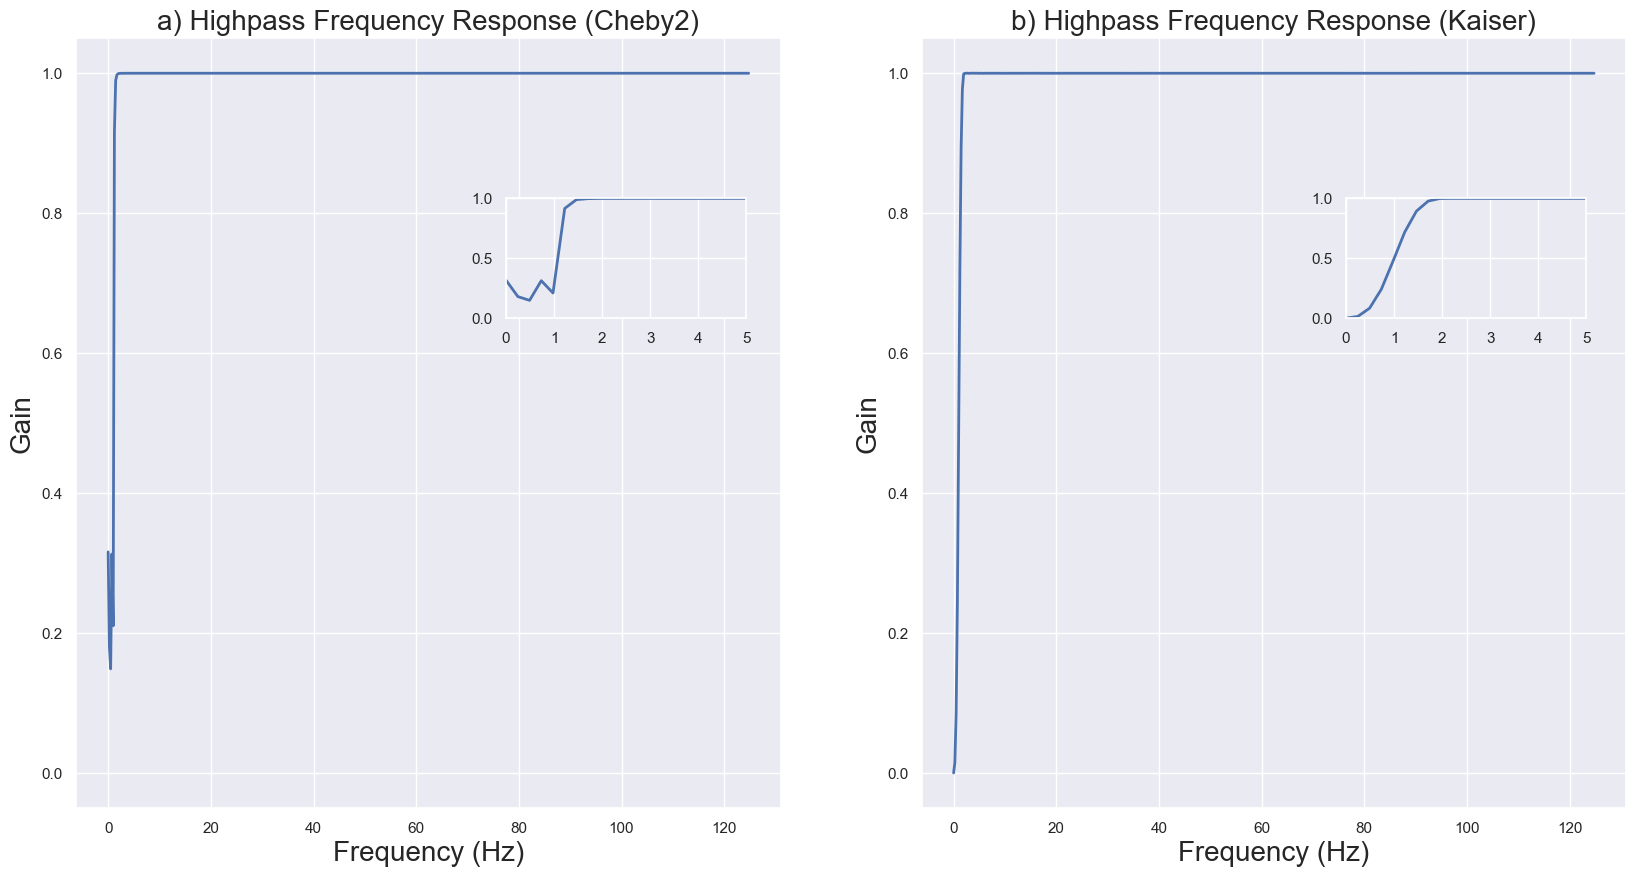

In [40]:
figure(1, figsize=(20,10))
clf()
grid(True)
subplot(1,2,1)
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('a) Highpass Frequency Response (Cheby2)', fontsize = 20)
ylim(-0.05, 1.05)

# Upper inset plot.
ax1 = axes([0.34, 0.6, 0.12, 0.12])
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Highpass Kaiser
subplot(1,2,2)
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('b) Highpass Frequency Response (Kaiser)', fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax2 = axes([0.76, 0.6, 0.12, 0.12])
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)

3. Final filter selection and effect in time and frequency domain.

C:\Users\Daydreamore\AppData\Local\Temp\ipykernel_20240\925536531.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,3,1)


Text(0.5, 1.0, 'Filtered vs. Raw Signal')

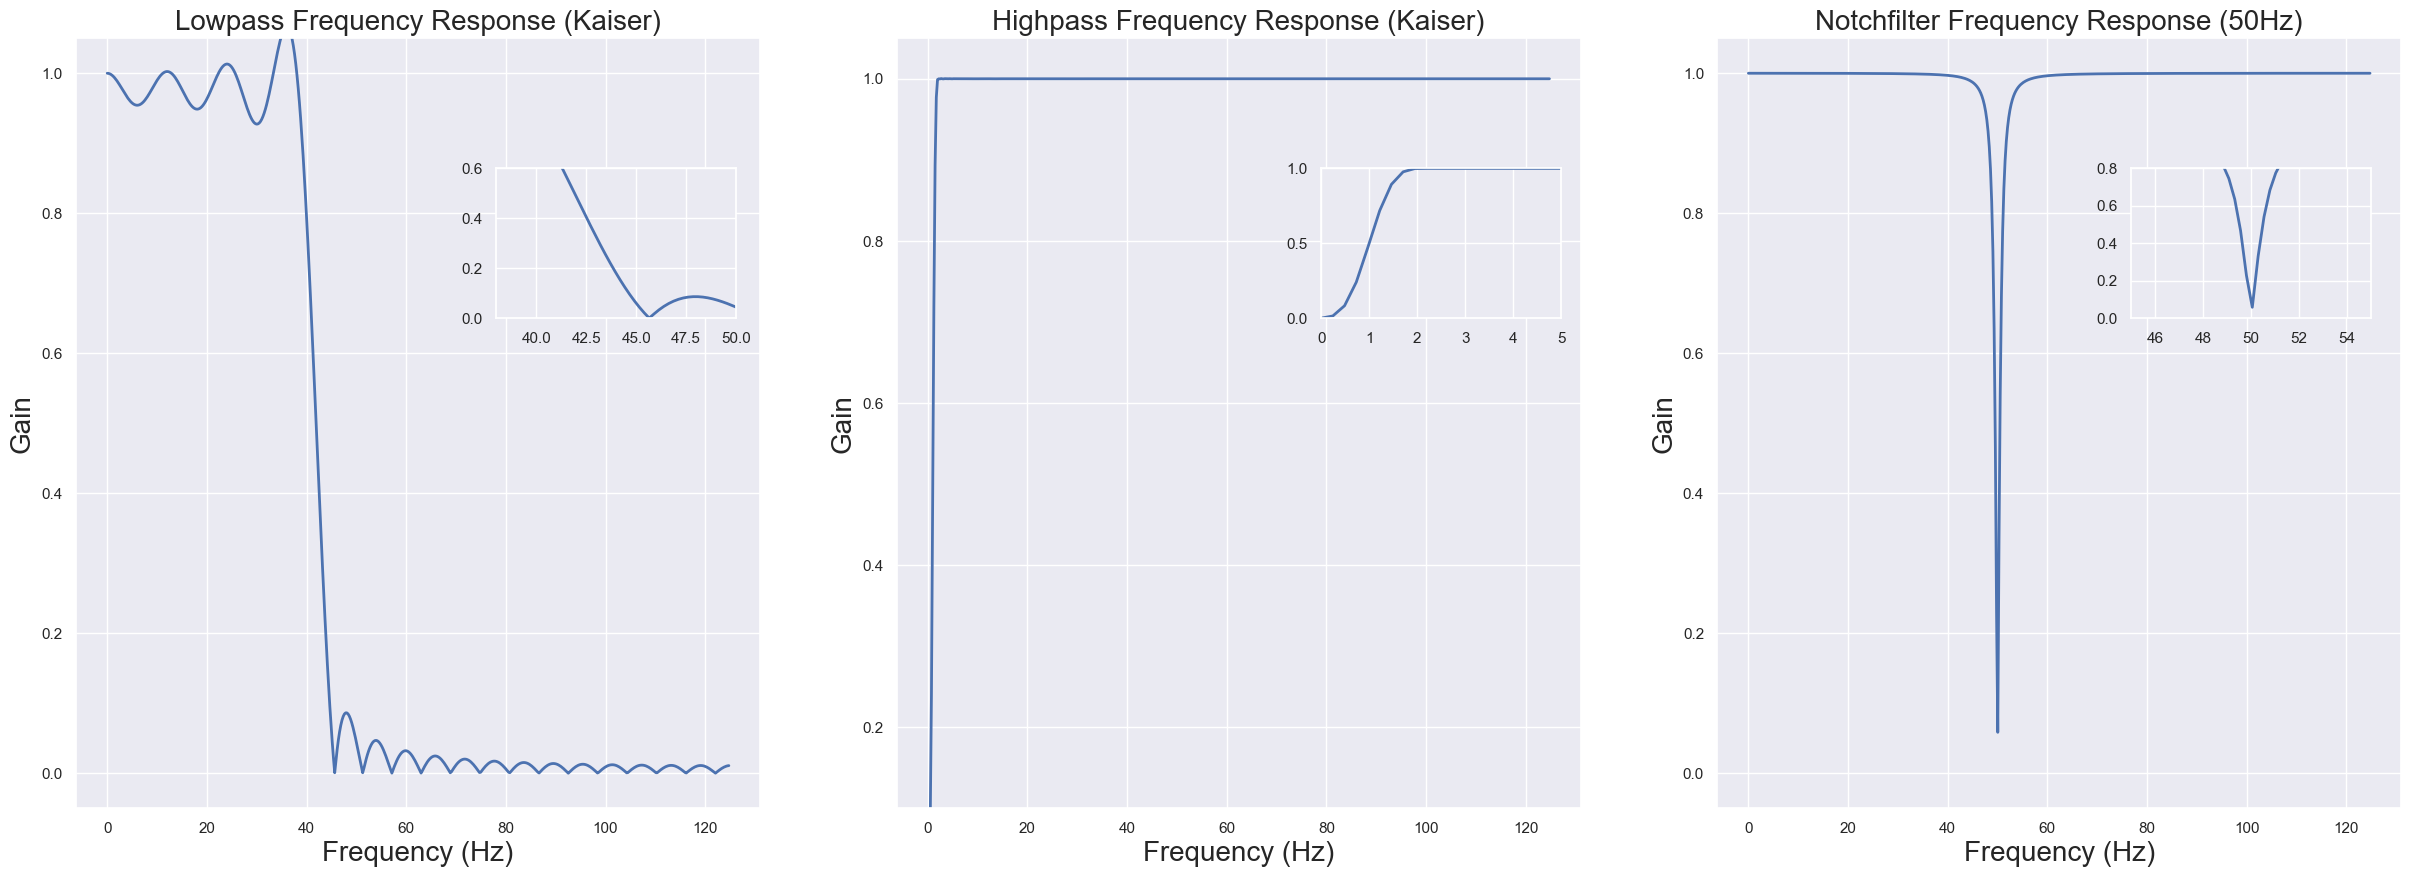

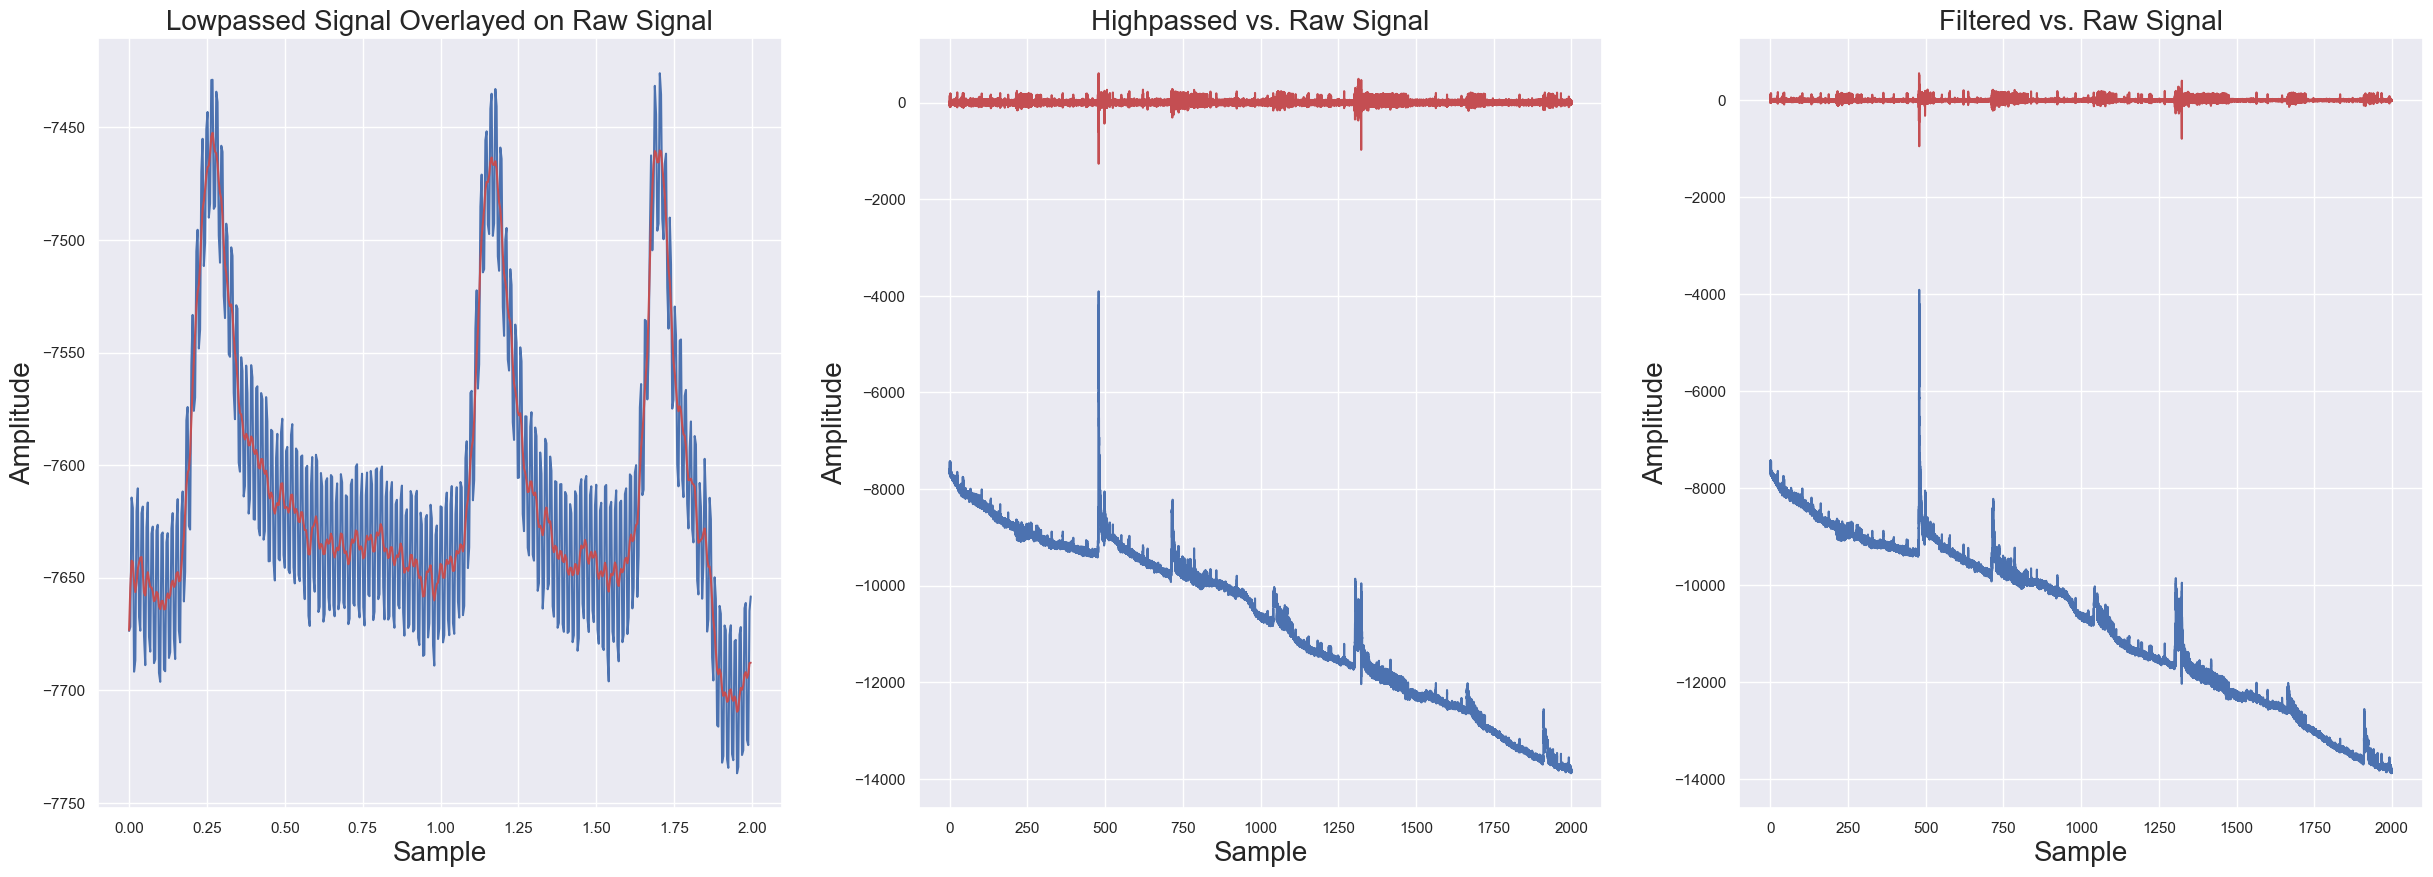

In [41]:
#Kaiser
#Highpass and Lowpass Filter 
#Width of transition from pass to stop relative to Nyquist.
width_low = 5.0/nyq 
width_high = 2.0/nyq

#Desired attenuation in the stop band, in dB.
ripple_db_low = 20.0
ripple_db_high = 72.0

#Compute the order and Kaiser parameter for the FIR filter.
N_low, beta_low = kaiserord(ripple_db_low, width_low)
N_high, beta_high = kaiserord(ripple_db_high, width_high)

#Use firwin with a Kaiser window to create a lowpass and highpass FIR filter.
taps_low = firwin(N_low, low_cut,window=('kaiser', beta_low)) #Kaiser: window=('kaiser', beta_low) or ('chebwin', 0.0002)
taps_high = firwin(N_high, high_cut, window=('kaiser', beta_high), pass_zero=False) 
w_h, h_h = freqz(taps_high, worN=512)
w_l, h_l = freqz(taps_low, worN=512)


#Notchfilters
b_50, a_50 = iirnotch(50.0, 30, fs=250)
b_62, a_62 = iirnotch(62.0, 30, fs=250)
b_100, a_100 = iirnotch(100.0, 30, fs=250)
w_50, h_50 = freqz(b_50, a_50, worN=512)


filter_coeffs = {
    "low": taps_low,
    "high": taps_high,
    "notch_50": (b_50, a_50),
    "notch_62": (b_62, a_62),
    "notch_100": (b_100, a_100)
    }


#Function to run all filters on an input array
def filter(data, filter_coeffs = filter_coeffs):
    '''
    Applies lowpass (42Hz), highpass (2Hz), and notchfilters (50 & 100Hz)

    Input:
    - data: 1d numpy array (1 channel)
    - filter_coeffs: dictionary containing filter coefficients for each filter

    Output:
    - filtered_data = filtered channel
    '''
    filtered_data = data
    for filter in filter_coeffs.keys():
        if type(filter_coeffs[filter]) == tuple:
            b, a = filter_coeffs[filter]
            filtered_data = filtfilt(b, a, filtered_data)
        else:
            filtered_data = filtfilt(filter_coeffs[filter], 1.0, filtered_data)
    return filtered_data


#Plotting:
#Filter Frequency Responses
#Lowpass
figure(1, figsize=(30,10))
clf()
grid(True)
subplot(1,3,1)
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Lowpass Frequency Response (Kaiser)', fontsize = 20)
ylim(-0.05, 1.05)


# Upper inset plot.
ax1 = axes([0.265, 0.6, 0.08, 0.15])
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlim(38,50)
ylim(0.0, 0.6)

#In case you would like to plot the filter coefficients
# figure(2)
# plot(taps_high, 'bo-', linewidth=2)
# title('Firwin: Highpass Filter Coefficients (%d taps)' % N_high)
# grid(True)


#Highpass
subplot(1,3,2)
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Highpass Frequency Response (Kaiser)', fontsize = 20)
ylim((0.1, 1.05))

#Upper inset plot.
ax2 = axes([0.54, 0.6, 0.08, 0.15])
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Notch
subplot(1,3,3)
plot((w_50/np.pi)*nyq, np.absolute(h_50), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Notchfilter Frequency Response (50Hz)', fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax3 = axes([0.81, 0.6, 0.08, 0.15])
plot((w_50/np.pi)*nyq, np.absolute(h_50), linewidth=2)
xlim(45,55)
ylim(0.0, 0.8)


#Filters in Time Domain
figure(2, figsize=(30,10))
subplot(1,3,1)
x = np.load("sub1_data.npy", allow_pickle=True)
t = np.arange(0,500,1)/fs
plot(t,x[0,0:500])
filtered_x = filtfilt(b_l, a_l, x) #apply lp
plot(t, filtered_x[0,:500], "r-")
xlabel('Sample', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Lowpassed Signal Overlayed on Raw Signal', fontsize = 20)

subplot(1,3,2)
t = np.arange(0,500000,1)/fs
plot(t,x[0,:500000])
filtered_x = filtfilt(taps_high, 1.0, x) #apply hp
plot(t, filtered_x[0,:500000], "r-")
xlabel('Sample', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Highpassed vs. Raw Signal', fontsize = 20)

subplot(1,3,3)
t = np.arange(0,500000,1)/fs
plot(t,x[0,:500000])
filtered_x = filter(x, filter_coeffs) #apply all filters
plot(t, filtered_x[0,:500000], "r-")
xlabel('Sample', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Filtered vs. Raw Signal', fontsize = 20)


4. Filtered signal and PSD plot.

(0.0, 0.1)

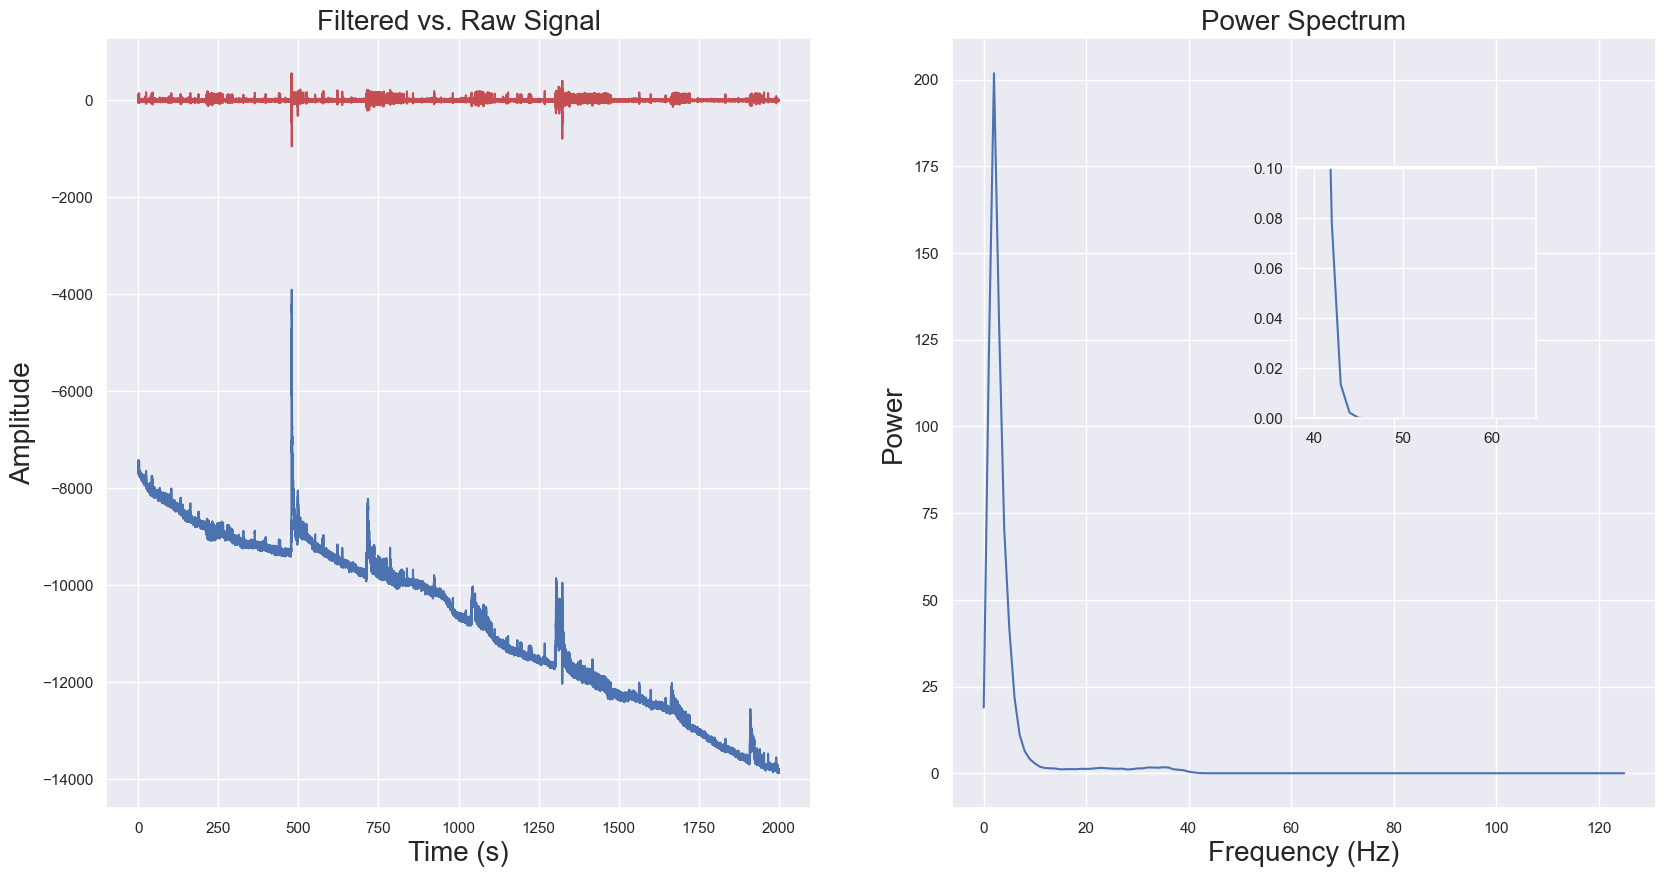

In [45]:
figure(1, figsize=(20,10))
subplot(1,2,1)
t = np.arange(0,500000,1)/fs
plot(t,x[0,:500000])
filtered_x = filter(x, filter_coeffs) #apply all filters
plot(t, filtered_x[0,:500000], "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Filtered vs. Raw Signal', fontsize = 20)

#PSD
subplot(1,2,2)
freq, power = welch(filtered_x[0,:], fs = 250, nperseg = 250)
plot(freq,power)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Power', fontsize = 20)
title('Power Spectrum', fontsize = 20)

ax3 = axes([0.72, 0.5, 0.12, 0.25])
plot(freq,power)
xlim(38,65)
ylim(0.0, 0.1)

Alternatively, a cheby highpass filter can be used. It is a tradeoff between retaining a bit more of the lower frequencies (Cheby) vs. improved filtering of DC (Kaiser).
Notably, with the setup of the Cheby HP filter, we still observe a shift.

intro, methods, result+discussion in one

## Preprocessing

First, let's ensure that the position of sensors (and especially channel O2) is at the same position for each subject.
Despite the fact that the channel key is different, "O2" is the third of the selected channels for each participant.

In [43]:
chan_select = np.array(["PO3", "PO4", "PO8", "O2", "Pz", "P3", "P4", 
                        "CPz","CP1", "CP2","Cz"])
for i in range(16):
    j = i+1
    path = "sub{}_label.csv".format(j)
    labels = pd.read_csv(path).values
    print(f"Subject {j}: ")
    for chan in chan_select:
        count = -1
        for label in labels:
            count += 1
            if (label == chan)[0]:
                print("{}: {}".format(label, count))
        

Subject 1: 
['PO3']: 8
['PO4']: 23
['PO8']: 7
['O2']: 9
['Pz']: 22
['P3']: 14
['P4']: 15
['CPz']: 18
['CP1']: 12
['CP2']: 13
['Cz']: 17
Subject 2: 
['PO3']: 8
['PO4']: 23
['PO8']: 7
['O2']: 9
['Pz']: 22
['P3']: 14
['P4']: 15
['CPz']: 18
['CP1']: 12
['CP2']: 13
['Cz']: 17
Subject 3: 
['PO3']: 7
['PO4']: 22
['PO8']: 6
['O2']: 8
['Pz']: 21
['P3']: 13
['P4']: 14
['CPz']: 17
['CP1']: 11
['CP2']: 12
['Cz']: 16
Subject 4: 
['PO3']: 7
['PO4']: 22
['PO8']: 6
['O2']: 8
['Pz']: 21
['P3']: 13
['P4']: 14
['CPz']: 17
['CP1']: 11
['CP2']: 12
['Cz']: 16
Subject 5: 
['PO3']: 7
['PO4']: 22
['PO8']: 6
['O2']: 8
['Pz']: 21
['P3']: 13
['P4']: 14
['CPz']: 17
['CP1']: 11
['CP2']: 12
['Cz']: 16
Subject 6: 
['PO3']: 7
['PO4']: 22
['PO8']: 6
['O2']: 8
['Pz']: 21
['P3']: 13
['P4']: 14
['CPz']: 17
['CP1']: 11
['CP2']: 12
['Cz']: 16
Subject 7: 
['PO3']: 7
['PO4']: 22
['PO8']: 6
['O2']: 8
['Pz']: 21
['P3']: 13
['P4']: 14
['CPz']: 17
['CP1']: 11
['CP2']: 12
['Cz']: 16
Subject 8: 
['PO3']: 8
['PO4']: 23
['PO8']: 7
['

Below is an example of how filtering would change a sequence of a channel.

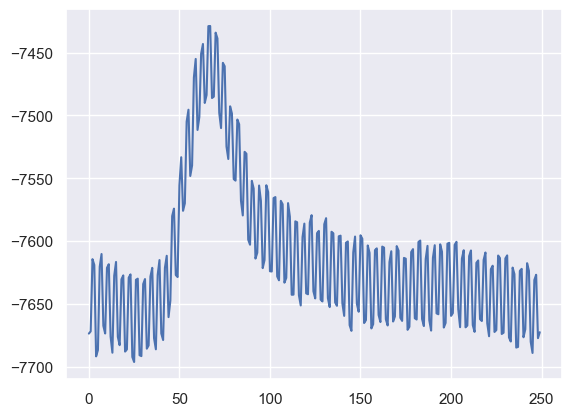

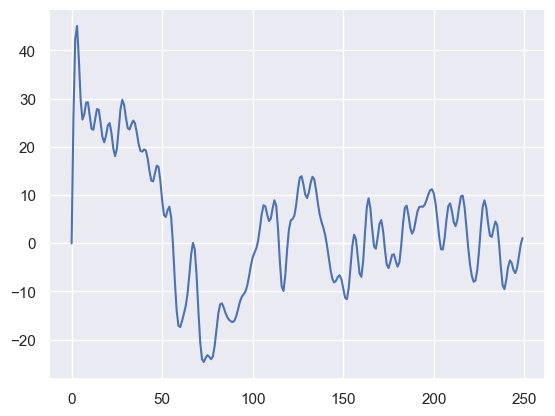

In [44]:
data_path = "sub1_data.npy"
data = np.load(data_path, allow_pickle=True)
n_chan = chan_select.shape[0]
plt.figure()
plt.plot(data[0, 0:250])
plt.show()

#Select channels
chans_bool = np.in1d(labels, chan_select)
data = data[chans_bool, :]

#Apply filtering
filter_coeffs = {
"low": taps_low,
"high": taps_high,
"notch_50": (b_50, a_50),
"notch_62": (b_62, a_62),
"notch_100": (b_100, a_100)
}
for i in range(n_chan):
    data[i,:] = filter(data[i,:], filter_coeffs = filter_coeffs)

plt.figure()
plt.plot(data[0, 0:250])
plt.show()

Preprocess data once for visualization and and once for later classification. Save both in .npy files for repeated use.

In [46]:
markers = {"control": "S13","explosion": "S12", "fire": "S14"}
chan_select = np.array(["PO3", "PO4", "PO8", "O2", "Pz", "P3", "P4", 
                        "CPz","CP1", "CP2","Cz"])
filter_coeffs = {
    "low": taps_low,
    "high": taps_high,
    "notch_50": (b_50, a_50),
    "notch_62": (b_62, a_62),
    "notch_100": (b_100, a_100)
    }
                     
for i in range(16):
    sub = "sub{}".format(i+1)
    data_path = sub + "_data.npy"
    event_path = sub + "_event.csv"
    label_path = sub + "_label.csv"
    np.save(sub + "_preprocessed_visualization.npy", preprocess(data_path, event_path, label_path, markers, chan_select, filter_coeffs, before = 125))
    np.save(sub + "_preprocessed.npy", preprocess(data_path, event_path, label_path, markers, chan_select, filter_coeffs, before = 0))

The preprocessed files may be loaded as follows once they were created:

In [35]:
file = np.load("sub1_preprocessed.npy", allow_pickle=True).item()

## Replicate Stimulus-Response to complex audio-visual stimuli
Calculate the average response for visual-only and audio-visual, respectively.
For that, 38/40 stimulus trials and 38 randomly selected control trials are averaged per person and then we average over 8 subjects.

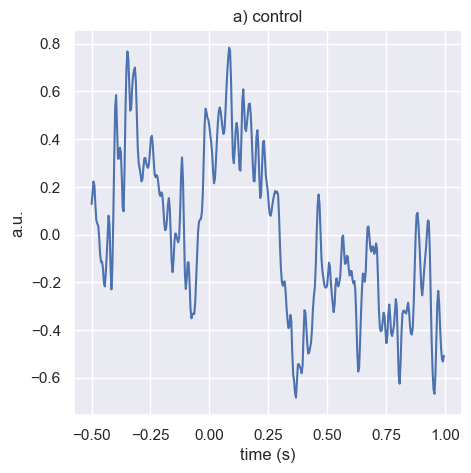

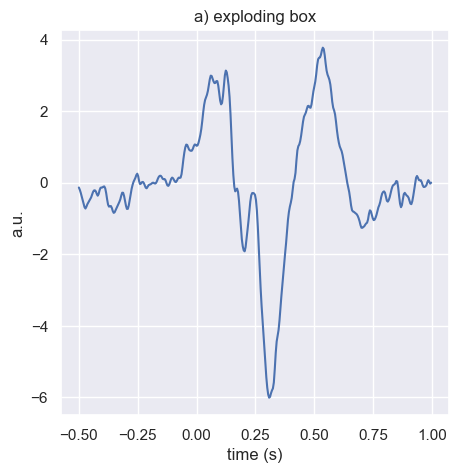

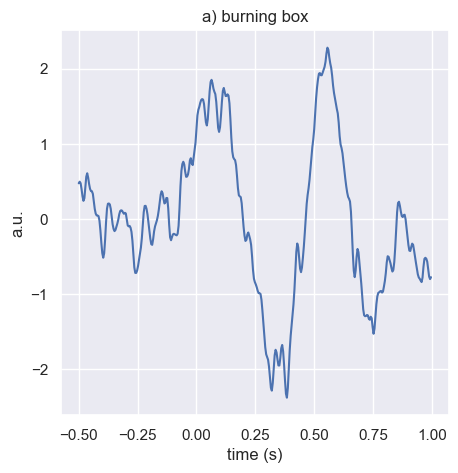

In [4]:
avg = {
    "control": [],
    "explosion": [],
    "fire": []
    }

std = avg.copy()

#Smoothing
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size


#Note: for the visualizations in the paper, the "O2" channel was used, which is the 3rd channel in the recordings
for i in range(8):
    j = i+8
    file = np.load("sub{}_preprocessed_visualization.npy".format(j), allow_pickle=True).item()
    for condition in file.keys():
        #randomly select 38 trials (and only use channel O2)
        select = np.array([file[condition][k][2,:] for k in np.random.choice(len(file[condition]), 38, replace=False)])
        avg[condition].append(np.mean(select, axis=0))
        std[condition].append(np.std(select, axis=0))

#Now, the dictionary contains a list and we need to average over the list for each condition
for ix, condition in enumerate(avg.keys()):
    #for further smoothing use: np.convolve(np.mean(np.array(avg[condition]), axis=0), kernel, mode='same')
    if condition == "explosion":
        title_cond = "exploding box"
    elif condition == "fire":
        title_cond = "burning box"
    else:
        title_cond = "control"
    avg_smooth = np.mean(np.array(avg[condition]), axis=0) 
    figure(ix, figsize = (5,5))
    plot(np.arange(-0.5,1, 1/250),avg_smooth-np.mean(avg_smooth))
    title(f"a) {title_cond}")
    ylabel("a.u.")
    xlabel("time (s)")